# Plasma Analysis

In [34]:
# Standard Packages
import numpy as np
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt

import gued


## Define Functions

### Processing Files

In [ ]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details_keV(file_names, sort=True):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage 
    positions, the file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        ir_stage_pos = []
        uv_stage_pos = []
        file_order = []
        current = []
        try:
            for file in file_names:
                string = list(map(str, file.split("\\")))
                temp = list(map(str, string[9].split(" ")))
                folder_number = temp[1]
                string = list(map(str, string[-1].split("_")))
                file_number = int(folder_number + string[1])
                file_order.append(int(file_number))
                ir_stage_pos.append(float(string[4]))
                uv_stage_pos.append(float(string[6]))
                current.append(float(string[-1][:-5]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    ir_stage_pos = np.array(ir_stage_pos)
    uv_stage_pos = np.array(uv_stage_pos)
    file_order = np.array(file_order)
    current = np.array(current)
    counts = get_counts(data_array)
    
    if sort == True:
        idx_sort = np.argsort(file_order)
        file_order = file_order[idx_sort]
        data_array = data_array[idx_sort]
        ir_stage_pos = ir_stage_pos[idx_sort]
        uv_stage_pos = uv_stage_pos[idx_sort]
        counts = counts[idx_sort]
        current = current[idx_sort]
    
    return data_array, ir_stage_pos, uv_stage_pos, file_order, counts, current

def get_fluorescence_details(file_names, sort=False):
    """
    Returns the data loaded from the tif files. Also returns arrays with the stage positions, the file order number, and the number of 
    counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    data_array = np.nanmean(data_array, axis = 3)
    print(data_array.shape)
    
    try:
        stage_pos = []
        file_numbers = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("\\")))
                stage_pos.append(float(string[-1][:-4]))
                file_name = string[-2][-1]
                file_name = file_name[:-4]
                file_numbers.append(file_name)
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
            Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_numbers = np.array(file_numbers)
    
    if sort == True:
        idx_sort = np.argsort(file_numbers)
        file_numbers = file_numbers[idx_sort]
        data_array = data_array[idx_sort]
        stage_pos = stage_pos[idx_sort]
    
    return data_array, stage_pos, file_numbers

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [10]:
dataPath = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\floresence\\plasma_01102024\\scan2'
runPath = "\\*\\*.tiff"


bkg_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\floresence\\plasma_01102024\\background_nolaser\\*\\*.tiff'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

dataPath ='C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\floresence\\fluorescence_01102024\\scan2'
runPath = "\\*\\*.tif"

newPath = dataPath + runPath
print(newPath)

fluor_files = glob.glob(newPath) 
print(len(fluor_files))

fluor_data, fluor_stage_pos, fluor_file_names = get_fluorescence_details(fluor_files[:])

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\floresence\plasma_01102024\scan2\*\*.tiff
C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\floresence\plasma_01102024\background_nolaser\*\*.tiff
545
20
C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\floresence\fluorescence_01102024\scan2\*\*.tif
436
(436, 1024, 1280)


### Plotting Example Image

In [35]:
test=tf.imread(files[0]);
bkg_sign='Yes'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _, _, _ = gued.get_image_details_keV(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(18,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.colorbar()
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

Load a image to check the signal level: C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\floresence\plasma_01102024\scan2\Images 1\Image_1_StagePos_np_26.5000_th_78.5000_Current_-15.79.tiff
Total number of images in the chosen directory is 545
Load background signal


ValueError: Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. 
                Also check separators

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [19]:
print('Load diffraction signal');
test_data, ir_pos, uv_pos, file_order, counts, current = get_image_details_keV(files)

Load diffraction signal


In [20]:
#good_range = np.concatenate((np.arange(1000, 2500, 1), np.arange(2800, 3300, 1)))
good_range = np.arange(1500, 1990, 1)
filter_data = 'no'

# if filter_data == 'yes':
#     test_data = test_data[good_range]
#     stage_positions = stage_positions[good_range]
#     counts = counts[good_range]
#     file_numbers = file_numbers[good_range]


if bkg_sign == 'Yes':
    test_data = test_data - bkg_ave

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage_ir = np.unique(ir_pos)     # Pump-probe stage position
uni_stage_uv = np.unique(uv_pos)


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage_ir))
print(len(np.unique(file_order)))
#print(file_numbers)

Image number read:  545
Stage positions:  109
545


### Visualizing Data Info

C:\Users\laure\AppData\Local\Temp\ipykernel_14548\140223838.py:19: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


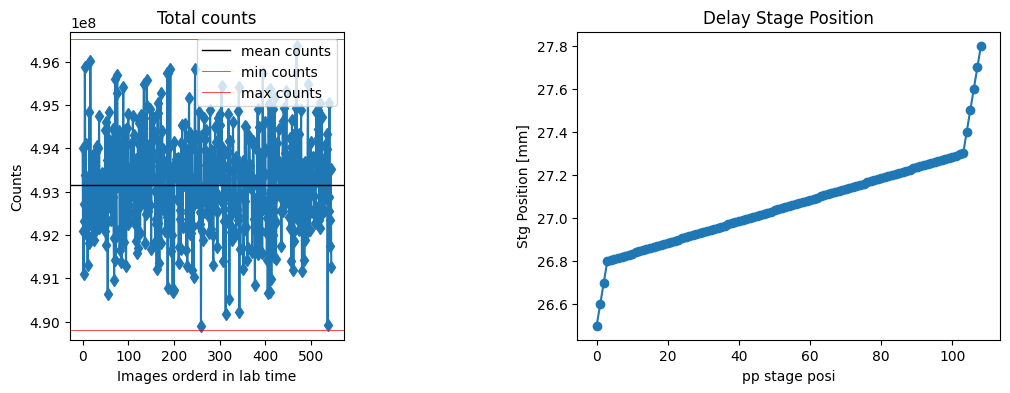

In [21]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,2,2) # Histogram the number of images at each posi
plt.plot(uni_stage_ir,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.tight_layout()
plt.show()

## Trim Data

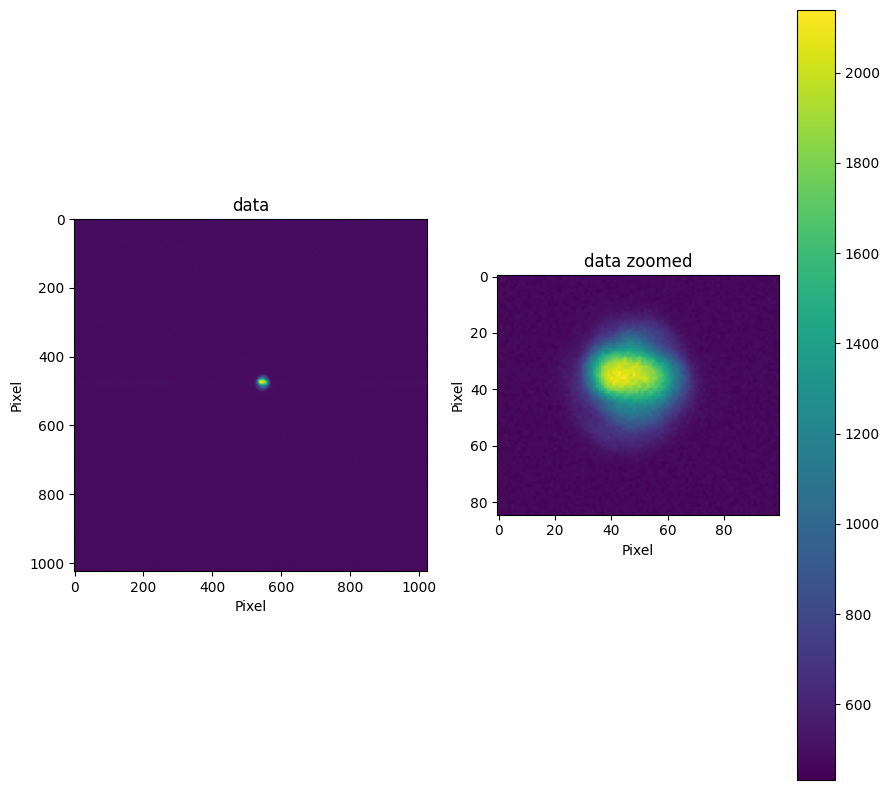

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test)
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data')

plt.subplot(1,2,2)
plt.imshow(test[440:525, 500:600]);
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('data zoomed')
plt.show()

trimmed_data = test_data[:, 440:525, 500:600]

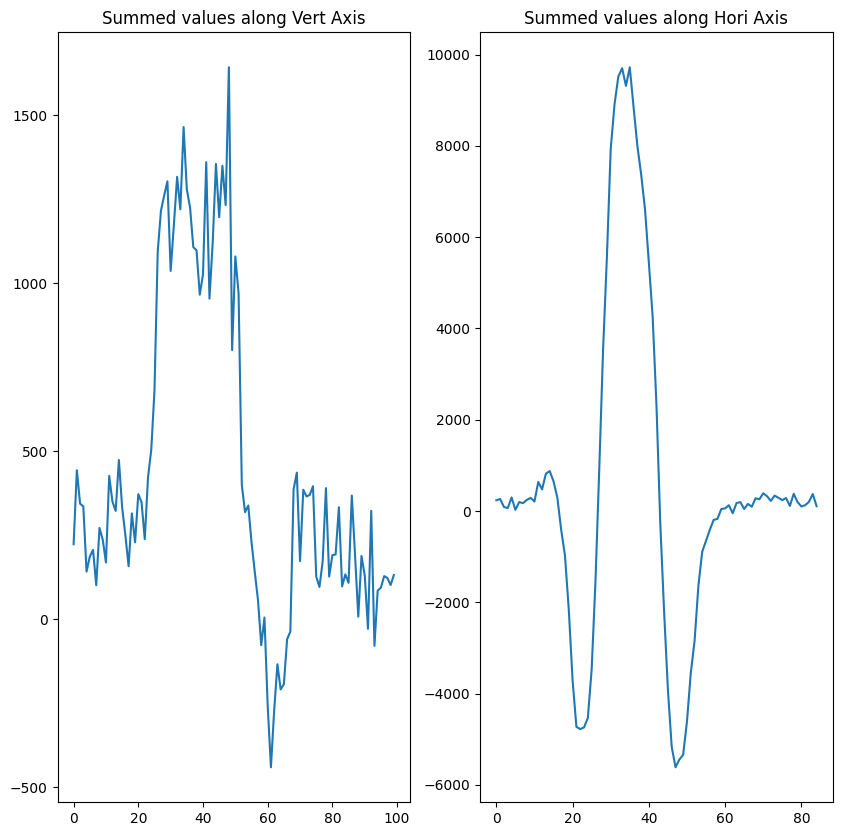

In [23]:
lineout_v = np.sum(trimmed_data, axis=1)
lineout_h = np.sum(trimmed_data, axis=2)
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(lineout_v[100])
plt.title("Summed values along Vert Axis")

plt.subplot(1,2,2)
plt.plot(lineout_h[100])
plt.title("Summed values along Hori Axis")
plt.show()

## Subtrack Baseline

In [24]:
corrected_v = []
corrected_h = []

for i in range(len(lineout_v)):
    baseline_v = np.mean((lineout_v[i, 0], lineout_v[i, -1]))
    baseline_h = np.mean((lineout_h[i, 0], lineout_h[i, -1]))
    temp_v = lineout_v[i] - baseline_v
    temp_h = lineout_h[i] - baseline_h
    corrected_v.append(temp_v)
    corrected_h.append(temp_h)
    
corrected_v = np.array(corrected_v)
corrected_h = np.array(corrected_h)

## Averaging Based on Delay Position

In [25]:
%%time
ir_stage_len = len(uni_stage_ir); #  Number of delays
ir_v_data = []
ir_h_data = []
current_ave = []

for i in range(ir_stage_len):
    h_ave = np.mean(lineout_h[np.where(ir_pos==uni_stage_ir[i])[0]], axis = 0);
    v_ave = np.mean(lineout_v[np.where(ir_pos==uni_stage_ir[i])[0]], axis = 0);
    curr_ave = np.mean(current[np.where(ir_pos==uni_stage_ir[i])[0]], axis=0)
    ir_h_data.append(h_ave)
    ir_v_data.append(v_ave)
    current_ave.append(curr_ave)
    
ir_v_data = np.array(ir_v_data)
ir_h_data = np.array(ir_h_data)
realtime = (uni_stage_ir-27)/0.15  # Delay axis in ps
print(ir_v_data.shape)
print(ir_h_data.shape)

(109, 100)
(109, 85)
CPU times: total: 0 ns
Wall time: 8.85 ms


## Find Peaks

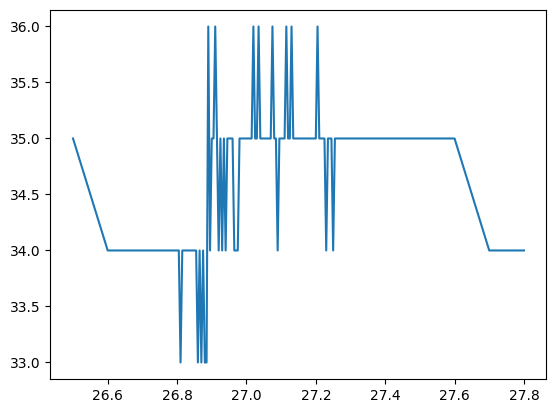

In [26]:
peaks_y = np.max(ir_h_data, axis=1)
peaks_x = np.argmax(ir_h_data, axis=1)

plt.figure()
plt.plot(uni_stage_ir, peaks_x)
#plt.xlim(26.6, 27.6)
plt.show()

## Plotting Data

c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Desktop\gued\.conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


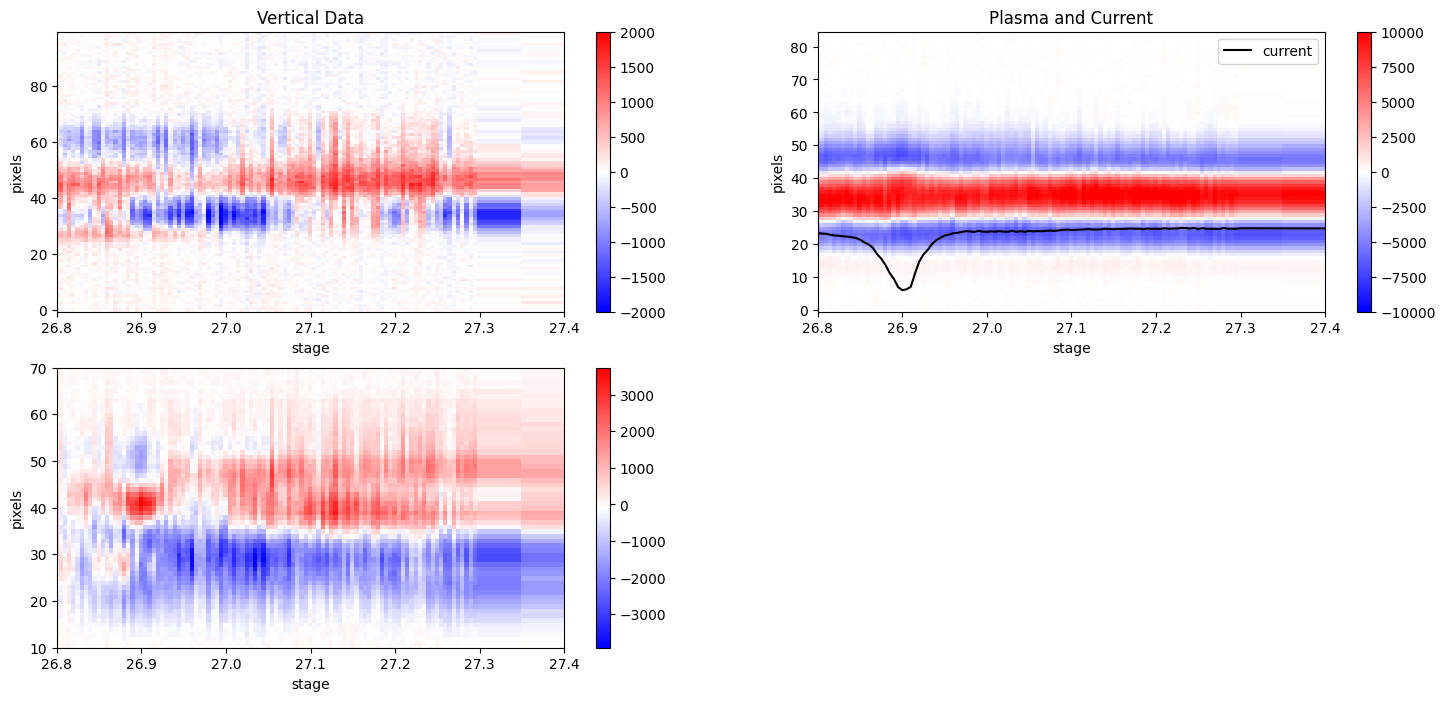

In [28]:
pixels_h = np.arange(0,len(ir_h_data[0]),1)
pixels_v = np.arange(0, len(ir_v_data[0]),1)

ref = np.nanmean(ir_h_data[:5], axis=0)
h_norm = (ir_h_data-ref); # Calculate the percentage difference signal

plt.figure(figsize=(18,8))
plt.subplot(2,2,1)
plt.pcolor(uni_stage_ir, pixels_v, ir_v_data.T, cmap="bwr")
plt.clim(vmin=-2000, vmax=2000)
plt.xlim(26.8, 27.4)
plt.ylabel("pixels")
plt.xlabel("stage")
plt.title("Vertical Data")
plt.colorbar()

plt.subplot(2,2,2,)
plt.pcolor(uni_stage_ir, pixels_h, ir_h_data.T, cmap="bwr")
plt.plot(uni_stage_ir, (np.array(current_ave)+40), "k", label="current")
plt.clim(vmin=-10000, vmax=10000)
plt.xlim(26.8, 27.4)
#plt.ylim(10,60)
plt.ylabel("pixels")
plt.xlabel("stage")
plt.title("Plasma and Current")
plt.legend()
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(uni_stage_ir, pixels_h, h_norm.T, cmap="bwr")
plt.colorbar()
#plt.clim(-1,1)
plt.xlim(26.8, 27.4)
plt.ylim(10, 70)
plt.ylabel("pixels")
plt.xlabel("stage")
plt.show()

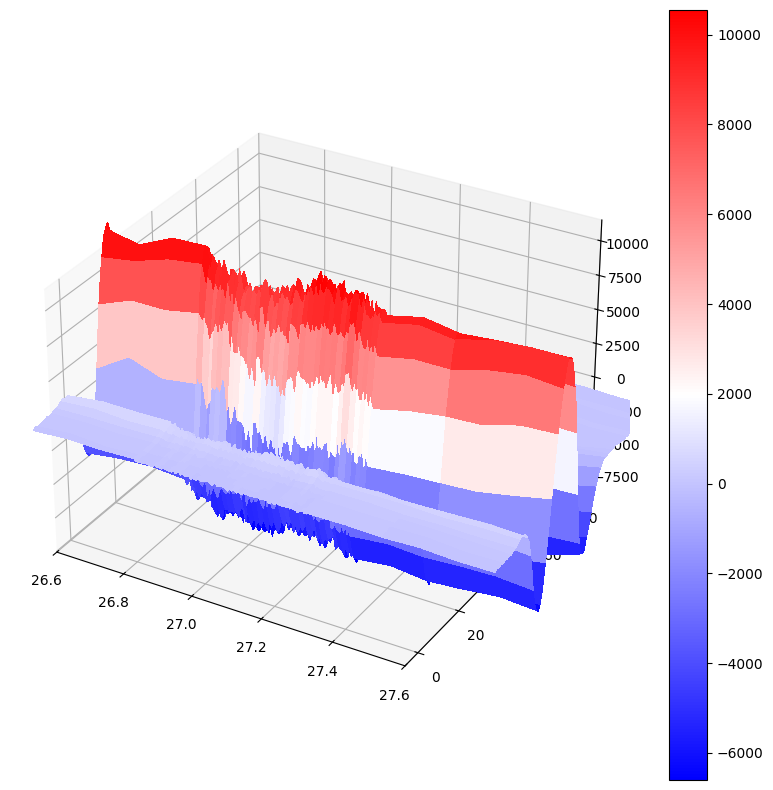

In [29]:
X, Y = np.meshgrid(uni_stage_ir, pixels_h)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, ir_h_data.T, cmap="bwr",
                       linewidth=0, antialiased=False)

ax.set_xlim(26.6, 27.6)
fig.colorbar(surf)

plt.show()


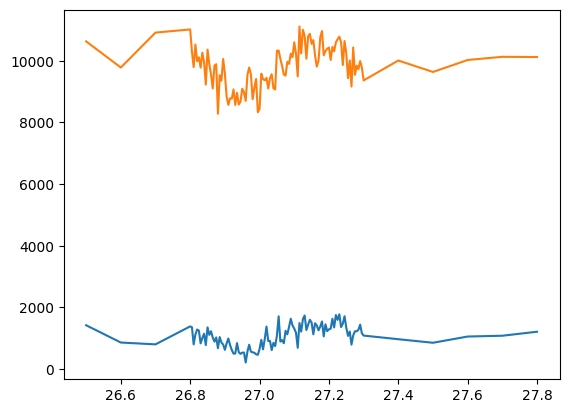

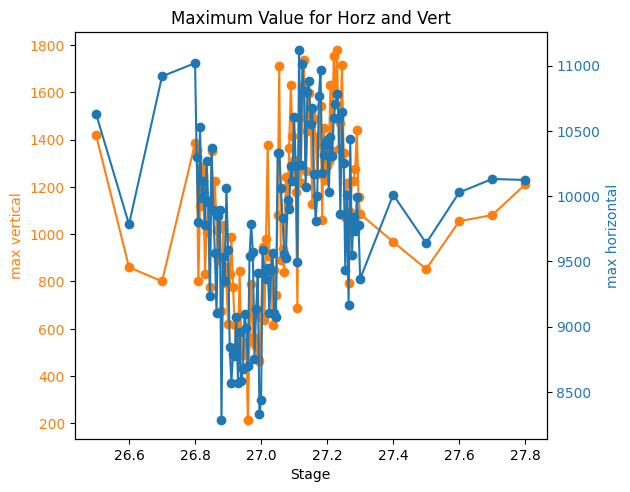

In [30]:
max_v = np.max(ir_v_data, axis=1)
max_h = np.max(ir_h_data, axis=1)

plt.figure()
plt.plot(uni_stage_ir, max_v)
plt.plot(uni_stage_ir, max_h)
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Stage')
ax1.set_ylabel('max vertical', color=color)
ax1.plot(uni_stage_ir, max_v, "-o", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('max horizontal', color=color)  # we already handled the x-label with ax1
ax2.plot(uni_stage_ir, max_h, "-o", color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Maximum Value for Horz and Vert")
plt.show()

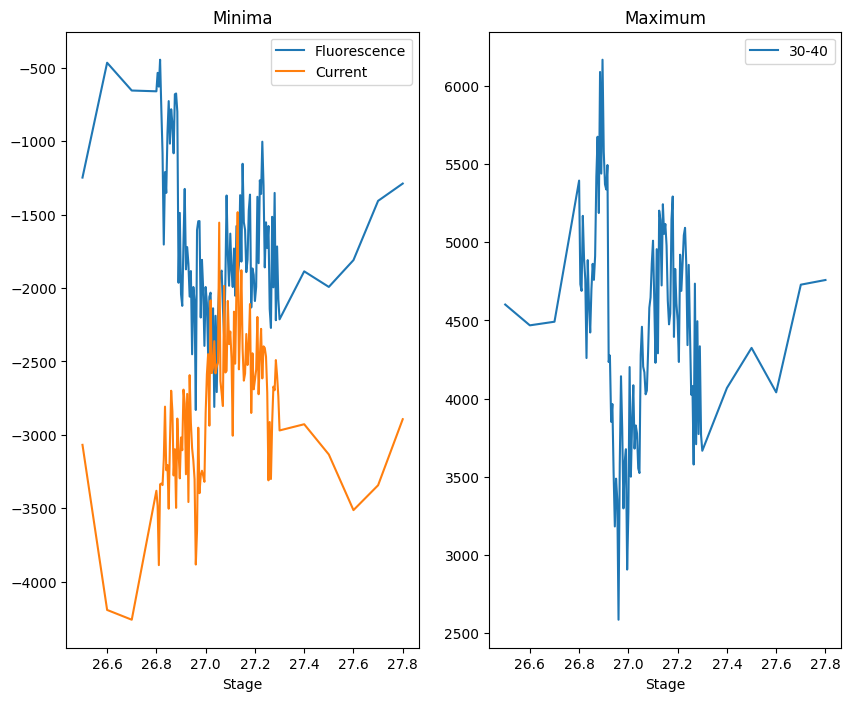

In [33]:
RoI_1 = [18,27]
RoI_2 = [30,40]
RoI_3 = [43,50]

region_1 = np.mean(ir_h_data[:, RoI_1], axis=1)
region_2 = np.mean(ir_h_data[:, RoI_2], axis=1)
region_3 = np.mean(ir_h_data[:, RoI_3], axis=1)

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(uni_stage_ir, region_1, label="Fluorescence")
plt.plot(uni_stage_ir, region_3, label="Current")
plt.xlabel("Stage")
plt.title("Minima")
plt.legend()

plt.subplot(1,2,2)
plt.plot(uni_stage_ir, region_2, label="30-40")
plt.xlabel("Stage")
plt.title("Maximum")
plt.legend()
plt.show()

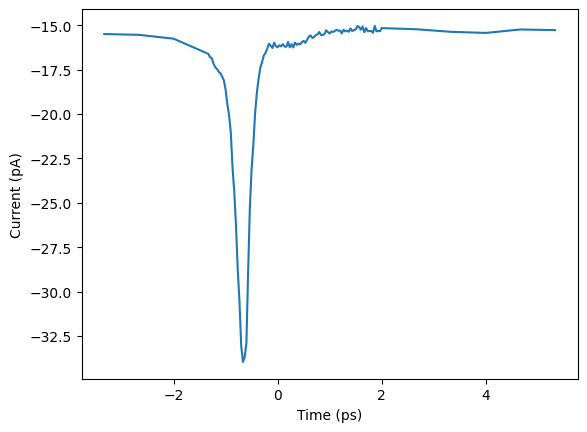

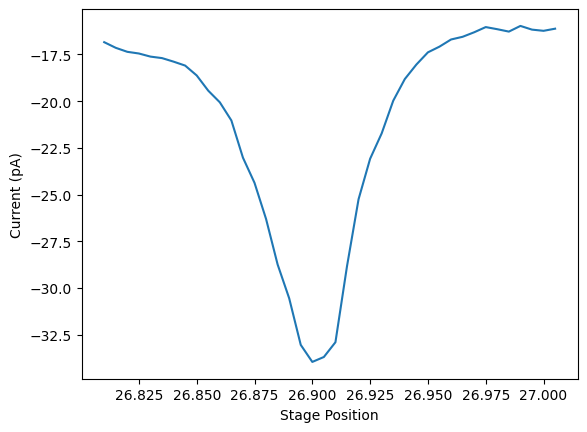

In [32]:
plt.figure()
plt.plot(realtime, current_ave)
plt.xlabel("Time (ps)")
plt.ylabel("Current (pA)")
plt.show()

plt.figure()
plt.plot(uni_stage_ir[5:45], current_ave[5:45])
plt.xlabel("Stage Position")
plt.ylabel("Current (pA)")
plt.show()

In [38]:
np.savetxt('/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/data_files/Fluorescence_Data/current_ave.txt', current_ave)